## Training Neural Netwok for Energy Prediction

**Cognio_NeuralNetwork_Forecaster** used a pre-trained model to provide a 24-hour forecast for energy consumption

Before we use the forecasting custom function **Cognio_NeuralNetwork_Forecaster**, we need to 
 1. Train a NN model, and
 2. Save the NN model in the model store database 
 
This notebook provides a walk-through to complete the above two steps

### Step 1: Training

a. Load the available data <br>
b. Visualize and understand the data<br>
c. Determine lenght of 24-hour prediction <br>
d. Build the feature vector for training <br>
e. Setup up model and start training <br>
f. Add additional training information we need to save for the Forecastor <br>
g. *(Optional)* save the trained  model <br>
h. *(Optional)* retrieve a trained model <br>
i. Perform output analysis <br>


In [1]:
#Data structures
import pandas as pd
import numpy as np
import datetime as dt

#plotting
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt

#Statistics
import math
import time
import scipy as sp
from sklearn import preprocessing, metrics
#Forecasting
import pyrenn as prn
#to disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['axes.grid'] = False

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

##### a. Load the available data into a dataframe

In [3]:
datapath='../data/IoTData.csv'
df = pd.read_csv(datapath, index_col=False, parse_dates=['DATETIME'])
df.head(5)

,DATETIME,TEMP_AIR,UMIDADE_REL,KW,KW2
0,2019-09-15 00:00:00,18.7,80.0,690.48,69.05
1,2019-09-15 01:00:00,18.2,83.0,685.44,68.54
2,2019-09-15 02:00:00,18.2,83.0,656.88,65.69
3,2019-09-15 03:00:00,18.2,83.0,655.20,65.52
4,2019-09-15 04:00:00,18.3,82.0,660.24,66.02


##### b. Visualize and summarize data

The customer time series data has the following properties
1. Hourly frequency
2. 351 days of hourly data
3. Features: [Energy consumption, Temperature, Humidity]

<AxesSubplot:title={'center':'Last 24 days of hourly data'}, xlabel='DATETIME', ylabel='KW'>

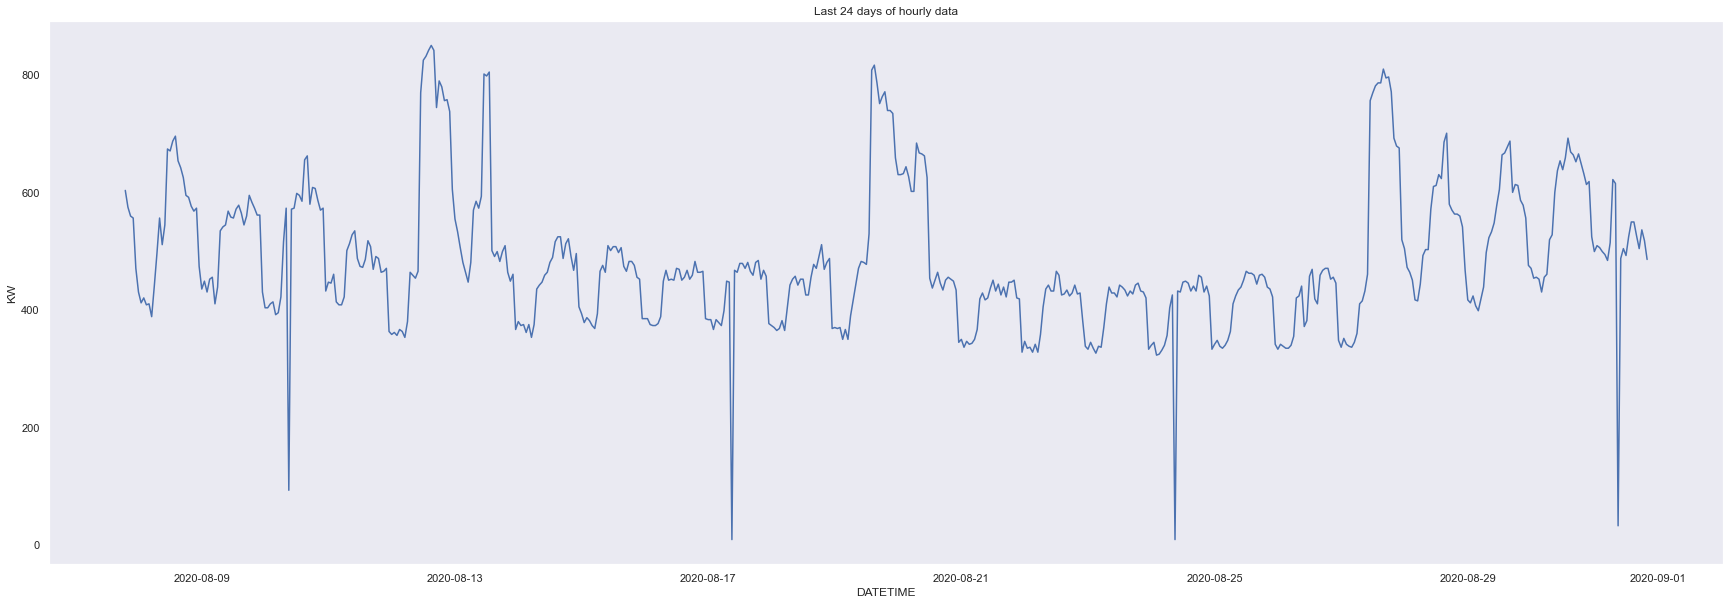

In [4]:
plot_size = (30, 10)
fig, ax = plt.subplots(figsize=plot_size)
plt.title("Last 24 days of hourly data")
sns.lineplot(x='DATETIME', y='KW', data=df[-24*24:])

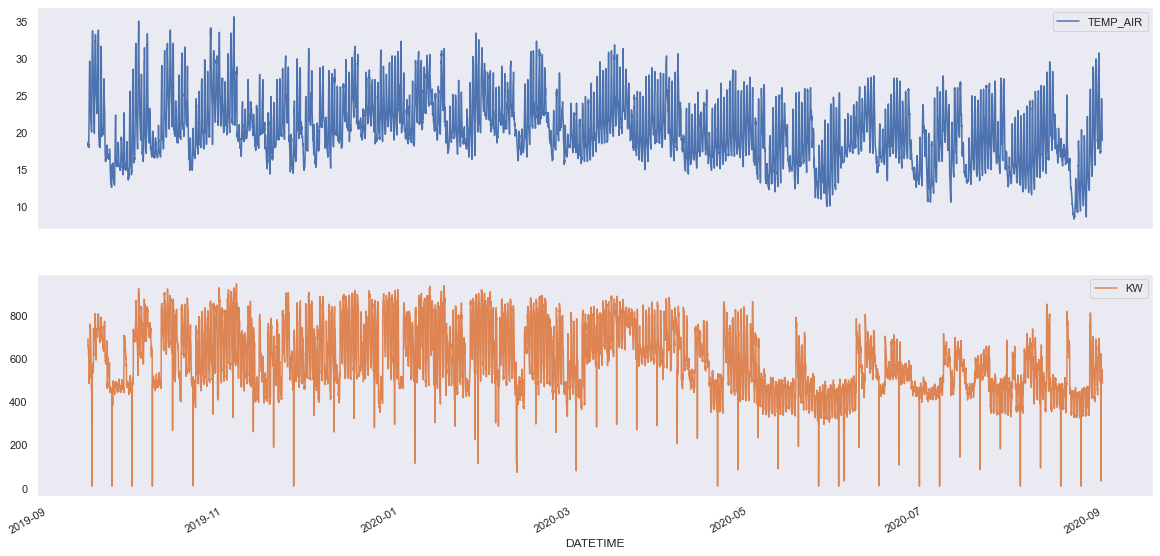

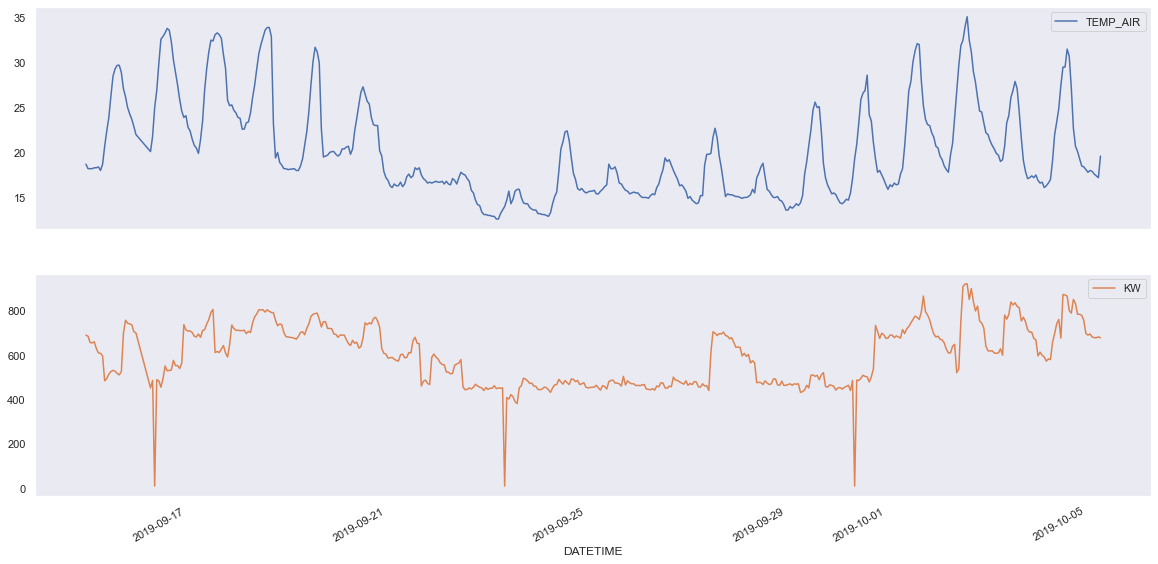

In [5]:
plot_cols = ['TEMP_AIR', 'KW']
plot_features = df[plot_cols]
plot_features.index = df.DATETIME
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = df.DATETIME[:480]
_ = plot_features.plot(subplots=True)

##### c. Determine validation period

"predict_days" will determine how much data to leave out for validation

In [6]:
predict_days = 24 * 5

##### d. Build feature vector for training

We're using the following features for our model <br>

    Feature 1        kw_lag_24                Power consumption at the same time of the previous day
    Feature 2        temp_lag_24              Tempeature at the same time of the previous day
    Features 3-27    hour_0 to hour_23        Hour of the day, one hot encoded
    Features 28-34   weekday_0 to weekday_6   Day of week, one hot encoded

In [7]:
hour_categories = [f'hour_{n}' for n in range(24)]
weekday_categories = [f'weekday_{n}' for n in range(7)]
feature_vector = ['kw_lag_24', 'temp_lag_24']
feature_vector.extend(hour_categories)
feature_vector.extend(weekday_categories)

feature_vector

['kw_lag_24',
 'temp_lag_24',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [8]:
#helper functions to build features
#In this pipeline this is done using FeatureBuilder custom function

def day_lag(df, time_col, current_time, ret_col, lag=1):
    try:
        #iloc[0] makes empty series error out so we return np.nan
        return df[df[time_col] == current_time - dt.timedelta(days=lag)].iloc[0][ret_col]
    except:
        if isinstance(ret_col, str):
            return np.nan
        else:
            return [np.nan] * len(ret_col)

In [9]:
#building features from original df

df_nn_ = df[['DATETIME', 'KW', 'TEMP_AIR']] # need these three columns from original data to build all the features
df_nn = df_nn_.loc[1:]

#1 building feature 1, 2
df_lag =  pd.DataFrame(data=[day_lag(df_nn, 'DATETIME', df_nn.iloc[i]['DATETIME'], ['KW', 'TEMP_AIR']) for i in range(df_nn.shape[0])], columns=['kw_lag_24', 'temp_lag_24'])
df_lag.index = df_nn.index

#2 building feature 3-27
df_nn['hour_of_day'] = df_nn.DATETIME.dt.hour
#one hot encoding hour of day
enc_hour = preprocessing.OneHotEncoder()
enc_hour.fit(df_nn['hour_of_day'].values[:df_nn.shape[0] - predict_days].reshape(-1,1))
enc_hour_val = enc_hour.transform(df_nn['hour_of_day'].values.reshape(-1,1)).toarray()
df_hour = pd.DataFrame(data=enc_hour_val,columns=hour_categories)
df_hour.index = df_nn.index

#3 building feature 28-34
df_nn['day_of_week'] = df_nn.DATETIME.dt.weekday
#one hot encoding day of week
enc_weekday = preprocessing.OneHotEncoder()
enc_weekday.fit(df_nn['day_of_week'].values[:df_nn.shape[0] - predict_days].reshape(-1,1))
enc_weekday_val = enc_weekday.transform(df_nn['day_of_week'].values.reshape(-1,1)).toarray()
df_weekday = pd.DataFrame(data=enc_weekday_val,columns=weekday_categories)
df_weekday.index = df_nn.index

df_nn = pd.concat([df_nn,df_hour, df_weekday, df_lag], axis=1)
df_nn.dropna(inplace=True)

In [10]:
#get the features ready for model
#performs data split for training and validation

train_up_to = df_nn.shape[0] - predict_days
X_train = df_nn[:train_up_to][feature_vector].T.to_numpy()
X_test = df_nn[:train_up_to]['KW'].values.reshape(-1, 1).T
Y_train = df_nn[train_up_to:][feature_vector].T.to_numpy()
Y_test = df_nn[train_up_to:]['KW'].values.reshape(-1, 1).T

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, train_up_to, df_nn[:train_up_to].shape #sanity check the shapes of all features

((33, 8086), (1, 8086), (33, 120), (1, 120), 8086, (8086, 38))

##### e. Setup up model and start training

**Model description** <br>

1. Architecture <br>
   1.1 Input layer >> Hidden layer (4 cells)  >> Hidden layer (4 cells)  >> Output layer <br>
   1.2 Hidden layers have tanh activation functions
   1.3 Termination on maximum iteration (k_max) or small error (E_stop)
   
2. Loss function <br>
   2.1 Mean Squared Error

3. Optimization <br>
   3.1 Levenberg–Marquardt algorithm

4. Scoring metrics <br>
   4.1 r2_score, RMSE , MAE, MAPE

In [11]:
net = prn.CreateNN([X_train.shape[0],4,4,X_test.shape[0]])

In [12]:
%%time
net = prn.train_LM(X_train,X_test,net,verbose=True,k_max=100,E_stop=1e1)

Iteration:  0 		Error:  7063.879102382509 	scale factor:  3.0
Iteration:  1 		Error:  370.90375922683916 	scale factor:  0.3
Iteration:  2 		Error:  134.18841510344836 	scale factor:  3.0
Iteration:  3 		Error:  111.82298584054821 	scale factor:  0.3
Iteration:  4 		Error:  97.54679456960349 	scale factor:  0.3
Iteration:  5 		Error:  91.57867680668406 	scale factor:  0.3
Iteration:  6 		Error:  90.52245125727057 	scale factor:  0.3
Iteration:  7 		Error:  89.3777901956991 	scale factor:  0.3
Iteration:  8 		Error:  88.01764059342621 	scale factor:  0.3
Iteration:  9 		Error:  86.7437086489053 	scale factor:  0.3
Iteration:  10 		Error:  85.9218481964835 	scale factor:  0.3
Iteration:  11 		Error:  85.50780850677114 	scale factor:  0.3
Iteration:  12 		Error:  85.26897311166488 	scale factor:  0.3
Iteration:  13 		Error:  85.08904606153475 	scale factor:  0.3
Iteration:  14 		Error:  84.93363772083032 	scale factor:  0.3
Iteration:  15 		Error:  84.79155543765903 	scale factor:  0.3
It

##### f. Add additional training information we need to save for the Forecastor

We need to save the one hot encoders we used on the training data for the inference engine (the inference engine is our custom function)

In [13]:
#save one hot encoders
net['OneHotEncoderHour'] = enc_hour
net['OneHotEncoderWeekday'] = enc_weekday

#save feature vectors
net['FeatureVector'] = feature_vector

##### g. (Optional) Save the trained model

Uncomment the lines below to save the trained model

In [14]:
# save_nn_path = f'../output/NN_Forecastor_{time.strftime("%Y%m%d-%H%M%S")}.csv'
# prn.saveNN(net,save_nn_path)

##### h. (Optional) Retrieve a saved model

Uncomment the line below to retrieve a saved model. Specify the path to the model you want to retrieve in "path_to_model" variable

In [15]:
# path_to_model = f'../output/NN_Forecastor_20201105-105833.csv'
# net = prn.loadNN(path_to_model)

#### Output Analysis

##### i. Perform output analysis to test out the model before saving it in the db

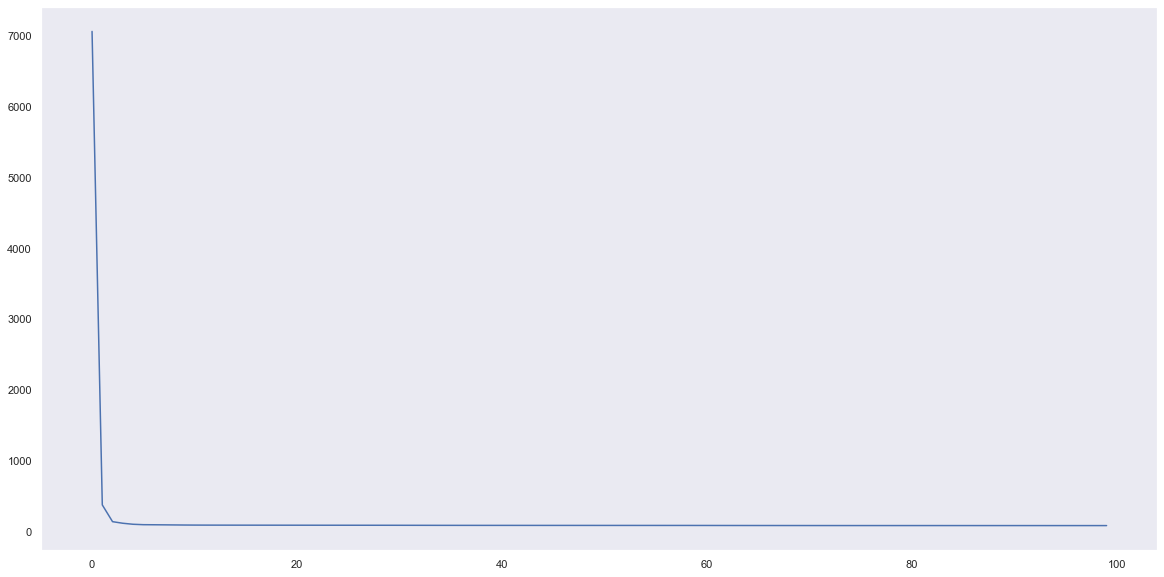

In [16]:
# i. plot training error
plt.plot(net['ErrorHistory'], label='Train Error')

In [17]:
# i. get training and validation prediction
y = prn.NNOut(X_train,net)
ytest = prn.NNOut(Y_train,net)

**r2_score** measures the correlation between the actual and predicted values<br>
**RMSE** gives more weight to outliers <br>
**MAE** measures how much we deviate from the actual values on average <br>
**MAPE** is used most commonly to forecast error. It works best when there are no extremes in data<br>

While MAE and MAPE frequenct errors RMSE focuses more on large infequent errors. A bigger difference between RMSE and MAE indicate inconsistent error sizes. MAPE has the advantage to being scale-agnostic, so we can compare the performance across different series

In [18]:
def mape(y_true, y_pred): 
    mask = y_true != 0
    return (np.fabs(y_true - y_pred)/y_true)[mask].mean()

print(
f'Training Output error analysis\n\
r2_score: {metrics.r2_score(X_test.T, y)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(X_test.T, y))} \n\
MAE: {metrics.mean_absolute_error(X_test.T, y)} \n\
MAPE: {mape(X_test,y)}'
)
print()
print(
f'Test Output error analysis\n\
r2_score: {metrics.r2_score(Y_test.T, ytest)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(Y_test.T, ytest))} \n\
MAE: {metrics.mean_absolute_error(Y_test.T, ytest)} \n\
MAPE: {mape(Y_test,ytest)}'
)

Training Output error analysis
r2_score: 0.638515295874077 
RMSE: 93.17913240475735 
MAE: 69.70835470147915 
MAPE: 0.16964200224882034

Test Output error analysis
r2_score: 0.3201896640049251 
RMSE: 102.07018463690171 
MAE: 71.60769710830769 
MAPE: 0.18507221591475673


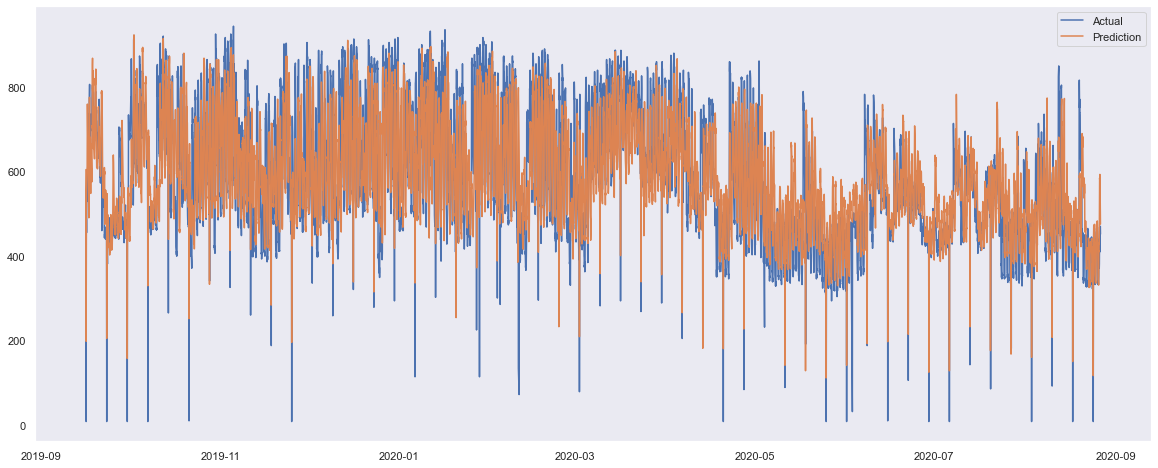

In [19]:
#plot training actual and prediction for visual analysis
plot_train = pd.DataFrame(df_nn[:train_up_to]['DATETIME'].values, columns=['DATETIME'])
plot_train['predicted_KW'] = y
plot_train['actual_KW'] = X_test.T
plot_train.set_index('DATETIME', inplace=True)

plt.figure(figsize=(20,8))
plt.plot(plot_train['actual_KW'], label="Actual")
plt.plot(plot_train['predicted_KW'], label="Prediction")
plt.legend(loc = 'best')

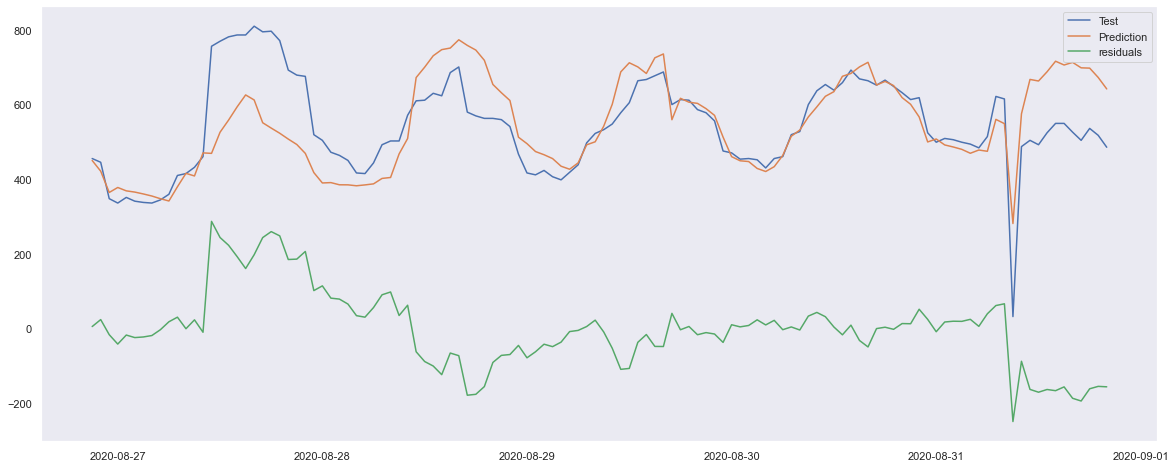

In [20]:
#plot testing actual and prediction for visual analysis
plot_test = pd.DataFrame(df_nn[train_up_to:]['DATETIME'].values, columns=['DATETIME'])
plot_test['predicted_KW'] = ytest
plot_test['actual_KW'] = Y_test.T
plot_test['residuals'] = plot_test['actual_KW'] - plot_test['predicted_KW']
plot_test.set_index('DATETIME', inplace=True)

plt.figure(figsize=(20,8))
plt.plot(plot_test['actual_KW'], label="Test")
plt.plot(plot_test['predicted_KW'], label="Prediction")
plt.plot(plot_test['residuals'], label="residuals")
plt.legend(loc = 'best')

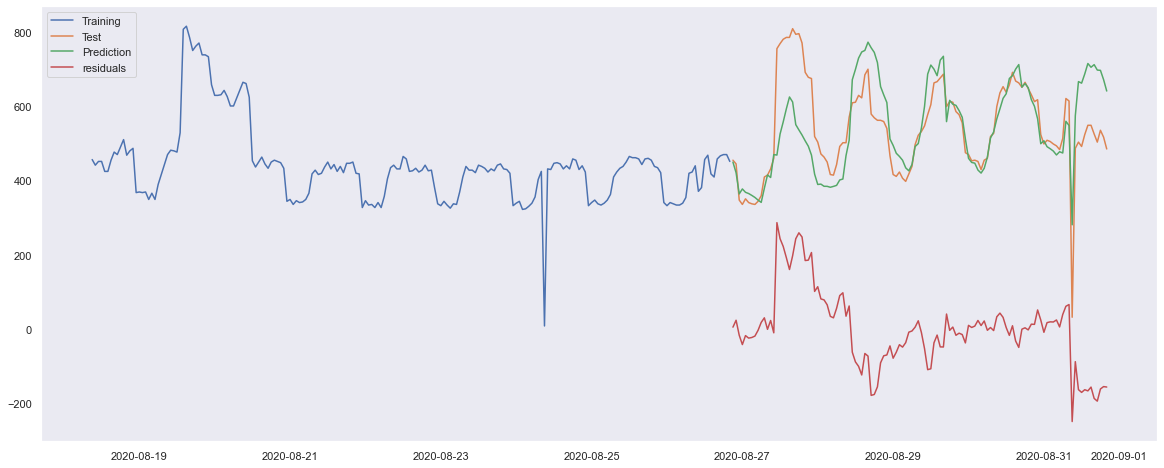

In [21]:
#plot everything together 
plt.figure(figsize=(20,8))
plt.plot(plot_train['actual_KW'][-200:], label="Training")
plt.plot(plot_test['actual_KW'], label="Test")
plt.plot(plot_test['predicted_KW'], label="Prediction")
plt.plot(plot_test['residuals'], label="residuals")
plt.legend(loc = 'best')
plt.show()

<AxesSubplot:xlabel='predicted_KW', ylabel='actual_KW'>

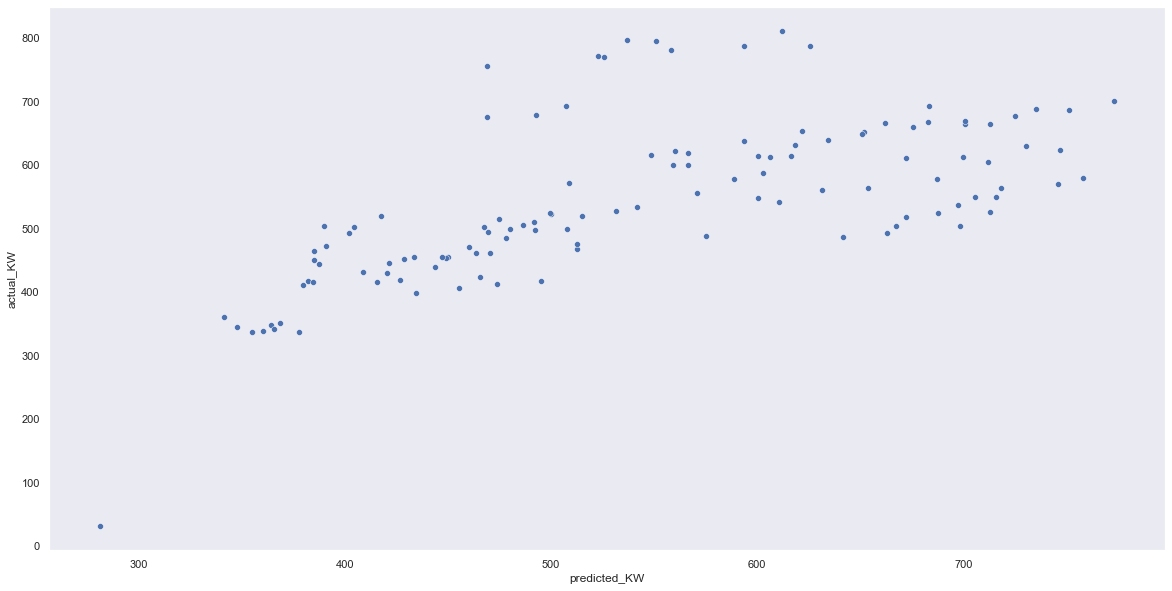

In [22]:
#correlation between predicted and actual KW in validation data
plot_size = (5, 5)
sns.scatterplot(x='predicted_KW', y='actual_KW', data=plot_test)

### Step 2: Saving the model

Currently we are saving the model for an entity type under the assumption that all entities will use the same model. This architecture will be fixed in furture versions <br>
You can register the same model for different entity types by running this part of the notebook multiple times and chaning the *entity_type* field

a. determine a model name <br>
b. load tenant credentials <br>
c. connect to the database <br>
d. store model <br>
e. test storing model by retrieving it <br>
f. *(Optional)* delete the model if you want to chage the name, re-train, other reasons

##### a. determine model name (the most important part) 

We need this name for the Cognio_NeuralNetwork_Forecaster custom function <br>
Specify the entity type you are registering this model for

In [23]:
entity_type = 'ENTEMP'
model_name  = 'Cognio_Neural_Netwok_Forecastor' + '_' + entity_type

##### b. load the credentials
The path to credential file is relative to this notebook

In [24]:
cedential_path = '../dev_resources/cognio.json'
import json
from iotfunctions.db import Database

with open(cedential_path, encoding='utf-8') as F:
    credentials = json.loads(F.read())

##### c. connect to the database with the entity type we're registering the model for

In [ ]:
db = Database(credentials=credentials, entity_type=entity_type)

In [ ]:
db.model_store.store_model(model_name, net)

##### e. test the model was saved correctly by accessing it

In [ ]:
db.model_store.retrieve_model(model_name)

##### f. (Optional) if you want to delete the above model you can uncomment the line below and run the cell

In [25]:
#db.model_store.delete_model(model_name)

### Step 3: Using the Cognio_NeuralNetwork_Forecaster

**From the Maximo Monitor dashboard** <br>
a. Use the ForecastBuilder custom function to create `kw_lag_24` and `temp_lag_24` calculated metrics for entity_type=demand4 (replace with entity type you are workng with) <br>
b. [Cognio_NeuralNetwork_Forecaster](https://github.com/singhshraddha/custom-functions/blob/development/custom/forecast.py) is a cutom function pre-registered with Cognio tenant. Follow these steps to get the predictions on the UI <br>
&emsp;b.1 Choose `Cognio_NeuralNetwork_Forecaster` custom function from the catalog <br>
&emsp;b.2 Set saved_model_name parameter to `Cognio_Neural_Netwok_Forecastor_demand4` (replace with entity_type's model) <br>
&emsp;b.2 Select `kw_lag_24` and `temp_lag_24` as the features parameter from the drop down <br>
&emsp;b.3 Specify the target/output name <br>